In [238]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector


pd.set_option("display.max_rows", 20)
pd.set_option('display.max_columns', 20)

### Import the dataframe containing tweets

In [239]:
df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)
df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0


#### Investigate basic components of the data

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          8936 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object 
 3   brand                                               3282 non-null   object 
 4   tweet_clean                                         8936 non-null   object 
 5   target                                              8936 non-null   float64
dtypes: float64(1), object(5)
memory usage: 488.7+ KB


In [241]:
df.target.value_counts(normalize=True)

0.0    0.602954
2.0    0.333259
1.0    0.063787
Name: target, dtype: float64

In [242]:
for i in df.columns:
    print(i)

tweet_text
emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product
brand
tweet_clean
target


In [243]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

## Emotion Value Breakdown

- No emotion       | 60.3%
- Positive emotion | 33.3%
- Negative emotion | 6.4%

This verges on perhaps being too imbalanced of a distribution and may require some sort of class weighting or synthetic resampling as we iterate through models. 

## Brand Breakdown

In [244]:
df.brand.isna().sum()

5654

#### Brands associated with the tweets

In [245]:
df.brand.fillna(value="missing").value_counts(normalize=True)

missing    0.632722
Apple      0.268800
Google     0.098478
Name: brand, dtype: float64

While knowing the brand names is not directly essential for our project, we may want to train a separate model to fill the nans with brand predictions from our model. It could at least be a fun exercise.

In [246]:
df.brand.value_counts()

Apple     2402
Google     880
Name: brand, dtype: int64

In [247]:
df[df['tweet_text'].str.contains('Google|google|Android|android', case=False)]['tweet_text'].shape

(2974,)

In [248]:
df[df['tweet_text'].str.contains('Apple|apple', case=False)]['tweet_text'].shape

(2102,)

### Filling null values with logical brands

In [249]:
df['imputed_brand'] = df['brand'].copy()

In [250]:
# Create a list of words    
google_words = ["Google", "google", "android", "Android"]
apple_words = ["Apple", "apple", 'iPad', "iPhone"]

# Fill nulls based on text of the tweet containing Google-ish terms
df['imputed_brand'].fillna(df['tweet_text'].apply(lambda x: "Google" if any(
    keyword in x for keyword in google_words) else None), inplace=True)
# Fill nulls based on text of the tweet containing Apple-ish terms
df['imputed_brand'].fillna(df['tweet_text'].apply(lambda x: "Apple" if any(
    keyword in x for keyword in apple_words) else None), inplace=True)

In [251]:
df['imputed_brand'].value_counts()

Apple     5011
Google    2919
Name: imputed_brand, dtype: int64

In [252]:
df.head(1)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple


In [253]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [254]:
df['imputed_brand'].isna().sum(), df['imputed_brand'].value_counts()

(1006,
 Apple     5011
 Google    2919
 Name: imputed_brand, dtype: int64)

In [255]:
df['brand'].isna().sum()

5654

In [256]:
df['brand'].value_counts()

Apple     2402
Google     880
Name: brand, dtype: int64

In [257]:
df.shape

(8936, 7)

### Filling the nulls in "imputed_brand"

In [258]:
df['imputed_brand'].fillna(value="Missing", inplace=True)

In [259]:
df['imputed_brand'].isna().sum(), df['imputed_brand'].value_counts()

(0,
 Apple      5011
 Google     2919
 Missing    1006
 Name: imputed_brand, dtype: int64)

### One Hot Encoding the brands

In [260]:
ohe = OneHotEncoder(sparse_output=False)
ohe_brands = ohe.fit_transform(df[['imputed_brand']])
ohe_df = pd.DataFrame(ohe_brands, columns=ohe.get_feature_names_out())
ohe_df.head()

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [261]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imputed_brand_Apple    8936 non-null   float64
 1   imputed_brand_Google   8936 non-null   float64
 2   imputed_brand_Missing  8936 non-null   float64
dtypes: float64(3)
memory usage: 209.6 KB


In [263]:
ohe_df.shape, df.shape

((8936, 3), (8936, 7))

In [269]:
# reset_index(drop = True) was required, the shapes were getting disjointed otherwise
concat_df = pd.concat([ohe_df.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
concat_df.shape

(8936, 10)

We have essentially added features for brand names of products that are being tweeted about, and one hot encoded those brands. Now our data is completely prepared for modeling iterations.

# Problem Description

Our task is to identify whether or not tweets have positive or negative emotions. From the assignment:

"There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix."

### Creating a binary dataframe: only positive or negative

In [270]:
concat_df.target.value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [271]:
binary_df = concat_df.loc[concat_df.target != 0].copy()

In [272]:
concat_df.shape, df.shape

((8936, 10), (8936, 7))

### Binary values of positive or negative only

In [273]:
binary_df.shape

(3548, 10)

In [274]:
binary_df.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,1.0,0.0,0.0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple
1,1.0,0.0,0.0,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0,Apple


In [275]:
binary_df.target.value_counts(normalize=True)

2.0    0.839346
1.0    0.160654
Name: target, dtype: float64

We have a ratio of more or less 5 - to - 1 Positive to negative. I will re-map the values of the target column so that "0" is a positive review, and "1" is a negative review.

### Modifying the column so values are 0 and 1, positive and negative respectively

In [276]:
binary_df['target'] = binary_df['target'].apply(lambda x: 0 if x == 2 else x)

#### Sanity Check

In [277]:
binary_df['target'].value_counts()

0.0    2978
1.0     570
Name: target, dtype: int64

### Preprocessing

Now that a binary column of 0's and 1's is in place, I will begin the process of preparing the tweets as tokens with the correct lemmatization, case, and removal of stop words. 

#### Re-examination of the df

In [278]:
binary_df.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,1.0,0.0,0.0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple
1,1.0,0.0,0.0,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,0.0,Apple


### Creating a function to handle all of the preprocessing tasks, borrowing from lecture material

In [279]:
### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


### This is the function that will be applied to the dataframe

In [280]:
def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc
    

# Defining a class to track the model iterations

### Initially created for multi-class classification

In [430]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
        
    def compare_roc_curve(self):
        # Color Palette
        colors = sns.color_palette(palette='gist_rainbow')
        # Create the plot
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right');
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [282]:
binary_df.columns

Index(['imputed_brand_Apple', 'imputed_brand_Google', 'imputed_brand_Missing',
       'tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product', 'brand',
       'tweet_clean', 'target', 'imputed_brand'],
      dtype='object')

# This is the full preprocessing of the tweet-strings

### Converting the original tweets into a new column

In [283]:
binary_df['tokens'] = binary_df['tweet_text'].apply(preprocess)

### Examination of how the tweets have been converted

In [284]:
binary_df['tokens'][0]

'wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw'

In [285]:
binary_df['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [286]:
# 1 is a negative experience
binary_df['target'][0]

1.0

# Vectorization of the data

In previous exercises, we have used the raw, un-edited text to represent our X variable and the label to represent our y variable. In this case, that would make "binary_df['tweet_text']" our X, and "binary_df['target']" our y. I am inclined to use the joined string of tokens as our X variable, and the labels as our y.

In [287]:
for i in binary_df.columns:
    print(i)

imputed_brand_Apple
imputed_brand_Google
imputed_brand_Missing
tweet_text
emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product
brand
tweet_clean
target
imputed_brand
tokens


In [288]:
# Assign the proper values to our X and y variables
X = binary_df[['tokens', 'imputed_brand_Apple', 'imputed_brand_Google', 'imputed_brand_Missing']]
y = binary_df['target']

### Only features currently are the text and the brand

In [289]:
X.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0


In [290]:
y[:2]

0    1.0
1    0.0
Name: target, dtype: float64

### Train/Test Split on the Data

In [291]:
# Train test split on the data, stratifying because of the relative imbalance of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [292]:
X_train.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
6087,rt mention join link start tonight person frie...,1.0,0.0,0.0
4758,head free google sponsor happy hour semantic w...,0.0,1.0,0.0


# Pipeline implementation

In [293]:
print(X_train["tokens"].shape)
print(X_train.shape)
print(X_train.columns)

(2661,)
(2661, 4)
Index(['tokens', 'imputed_brand_Apple', 'imputed_brand_Google',
       'imputed_brand_Missing'],
      dtype='object')


In [294]:
X_train.iloc[0:2]

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
6087,rt mention join link start tonight person frie...,1.0,0.0,0.0
4758,head free google sponsor happy hour semantic w...,0.0,1.0,0.0


# Pipelines are not working for me at the moment!!!!

In [147]:
# Step 1: Create a pipeline for the "brands" column
brands_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder())
])

# Step 2: Create a pipeline for the "tokens" column
tokens_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer())
])

# Step 3: Use a ColumnTransformer to apply the pipelines to the respective columns
column_transformer = ColumnTransformer([
    ('brands', brands_pipeline, ['imputed_brand']),
    ('tokens', tokens_pipeline, ['tokens'])
])

# Step 4: Create a final pipeline that includes the ColumnTransformer and a classifier
final_pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('classifier', DummyClassifier())
])

# Fit the final pipeline to your data
#final_pipeline.fit(X_train, y_train)


In [151]:
print(X_train.shape)
print(y_train.shape)

(2661, 2)
(2661,)


In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 6193 to 5646
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tokens         2661 non-null   object
 1   imputed_brand  2633 non-null   object
dtypes: object(2)
memory usage: 62.4+ KB


# MY PIPELINE

In [295]:
token_pipeline = Pipeline(steps=[
    ("vectorize", TfidfVectorizer())
])

brand_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("OHE", OneHotEncoder(sparse=False)),
    ("reshape", FunctionTransformer(lambda X: X.reshape(-1, 1), validate=False))
])



CT = ColumnTransformer(transformers=[
    ("brands", brand_pipeline, [['imputed_brand']]),
    ("vectorize", token_pipeline, [["tokens"]]),
])

dummy = Pipeline(steps=[
    ("CT", CT),
    ("dummy_classifier", DummyClassifier(strategy="most_frequent"))
])

# dummy.fit(X_train, y_train)

### Vectorizers: Count Vectorizer | TF-IDF Vectorizer

In [296]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer()
Xt_tfidf = tfidf.fit_transform(X_train['tokens'])

### Visual Inspection of the TF-IDF data

In [297]:
# Cell takes a couple minutes to run
df_tfidf = pd.DataFrame(Xt_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf.head(2)

,aapl,abacus,abandon,aber,ability,able,abroad,absolute,absolutely,abt,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
X_train.shape

(2661, 4)

# Functions to assist in re-combining vectorized text

In [348]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

In [349]:
X_train_transformed = combine_train_vectorization(X_train, "tokens", tfidf)

### General Sanity Check

In [350]:
X_train_transformed.shape

(2661, 4183)

In [351]:
X_test.shape

(887, 4)

In [352]:
X_test_transformed = combine_test_vectorization(X_test, "tokens", tfidf)
X_test_transformed.shape

(887, 4183)

In [353]:
X_train_transformed.iloc[0].idxmax()

'imputed_brand_Apple'

In [354]:
X_train_transformed.iloc[0].argmax()

0

In [355]:
X_train_transformed.columns[0]

'imputed_brand_Apple'

# First Dummy Model

In [356]:
dummy = DummyClassifier(strategy="most_frequent")

In [357]:
dummy.fit(X_train_transformed, y_train)

DummyClassifier(strategy='most_frequent')

In [358]:
dummy.score(X_train_transformed, y_train)

0.8391582111987974

In [359]:
y_train.value_counts(normalize=True)

0.0    0.839158
1.0    0.160842
Name: target, dtype: float64

By guessing the most frequent value, the dummy classifier correctly predicted the label 83.9% of the time, consistent with the distribution of labels in our training set. 

In [360]:
dummy.score(X_test_transformed, y_test)

0.8399098083427283

In [361]:
y_test.value_counts(normalize=True)

0.0    0.83991
1.0    0.16009
Name: target, dtype: float64

Again, the same is true for our test data. By choosing the class that occurs most frequently, our dummy classifier was correct at the exact frequency as the true distribution of our data. 

In [362]:
y_test.value_counts()

0.0    745
1.0    142
Name: target, dtype: int64

### Confusion Matrix: Dummy Model -> new method in new sklearn version

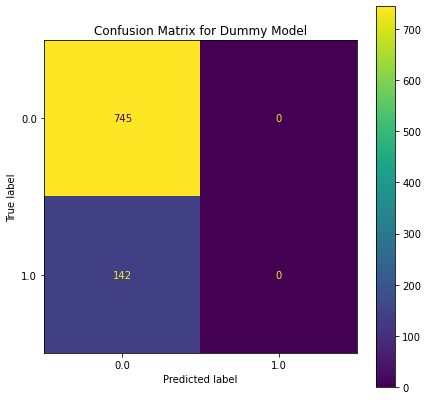

In [363]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(dummy, dummy.predict(X_test_transformed), y_test, ax=ax)
ax.set_title("Confusion Matrix for Dummy Model");

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


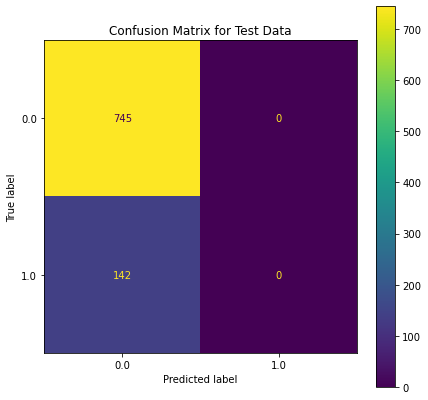

In [431]:
dummy_0 = Model("Dummy", dummy, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

In [432]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.0,0.0,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.5


In [366]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.0,0.0,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.5
1,Dummy,0.839158,0.0,0.0,0.0,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.5


### FSM Naive Bayes creation

In [367]:
mnb = MultinomialNB()

In [368]:
mnb.fit(X_train_transformed, y_train)

MultinomialNB()

In [369]:
# Scores on training data
mnb.score(X_train_transformed, y_train)

0.8489289740698985

In [370]:
X_train_transformed.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [371]:
X_test_transformed.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
print(X_train_transformed.shape, X_test_transformed.shape)

(2661, 4183) (887, 4183)


In [373]:
# Test the predictions on test data
y_preds = mnb.predict(X_test_transformed)
accuracy_score(y_test, y_preds)

0.8399098083427283

In [374]:
cross_validate(mnb, Xt_tfidf, y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.00353718, 0.0029881 , 0.00568199, 0.00318289, 0.00295901]),
 'score_time': array([0.01568484, 0.01358962, 0.01551604, 0.01172709, 0.01189423]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.84615385, 0.84962406, 0.84398496, 0.84398496, 0.84586466]),
 'test_recall': array([0.04651163, 0.05882353, 0.02352941, 0.03488372, 0.04651163]),
 'test_f1': array([0.08888889, 0.11111111, 0.04597701, 0.06741573, 0.08888889]),
 'test_neg_log_loss': array([-0.38521923, -0.3714225 , -0.38615195, -0.38585453, -0.42158848])}

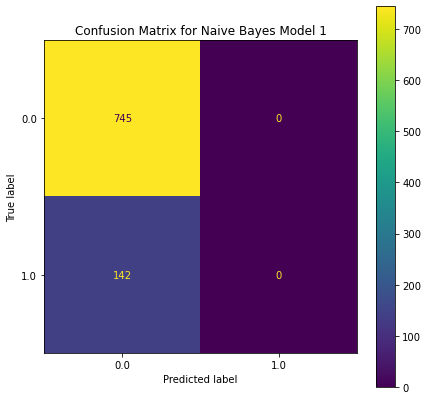

In [376]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(mnb, X=X_test_transformed, y=y_test, ax=ax)
ax.set_title("Confusion Matrix for Naive Bayes Model 1");

This baseline model exhibited a very slight improvement over our dummy classifier. The precision for class 1 is clearly too high to be useful. We will have to attempt to modify our model in order to improve the performance thereof.

In [378]:
pd.Series(mnb.predict(X_test_transformed)).value_counts(), "True Values:", "*" * 60, y_test.value_counts()

(0.0    887
 dtype: int64,
 'True Values:',
 '************************************************************',
 0.0    745
 1.0    142
 Name: target, dtype: int64)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


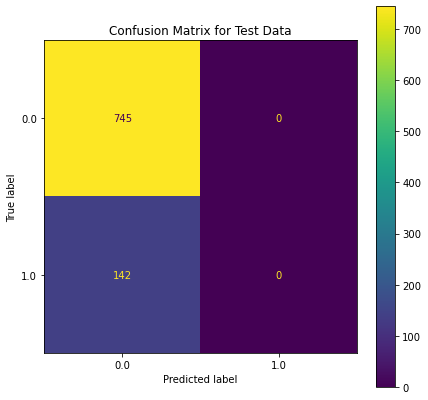

In [433]:
# I am receiving a warning about predictions not summing to 1, but everything seems to be working ok
mnb1 = Model("Naive Bayes 1", mnb, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

(0.7920313829284431, None)

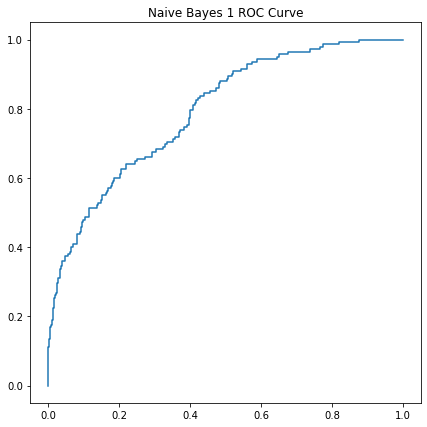

In [434]:
mnb1.auc, mnb1.roc_curve()

In [435]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.000000,0.000000,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.8,0.014036,0.027535,0.450482,0.83991,0.0,0.0,0.0,0.485984,0.792031


### Comparing the TF-IDF Vectorizer with a basic Count Vectorizer

In [382]:
X_train.columns

Index(['tokens', 'imputed_brand_Apple', 'imputed_brand_Google',
       'imputed_brand_Missing'],
      dtype='object')

In [385]:
# Count Vectorizer
count_v = CountVectorizer()
Xt_count = combine_train_vectorization(X_train, "tokens", count_v)
X_test_count = combine_test_vectorization(X_test, 'tokens', count_v)

In [386]:
mnb_count = MultinomialNB()
mnb_count.fit(Xt_count, y_train)

MultinomialNB()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


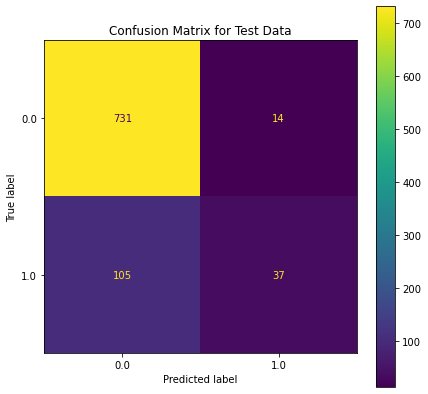

In [436]:
mnb_count1 = Model("MNB Count Vect", mnb_count, count_v, Xt_count, X_test_count, y_train, y_test)

In [437]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.83991,0.00000,0.000000,0.00000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.83991,0.00000,0.000000,0.00000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.86584,0.72549,0.260563,0.38342,0.569251,0.819283


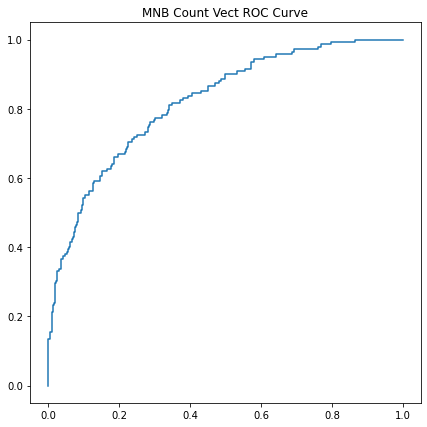

In [438]:
mnb_count1.roc_curve()

In [228]:
# count_auc_plot = mnb_count1.roc_curve()
# tfidf_auc_plot = mnb1.roc_curve()

# fig, ax = plt.subplots(figsize=(7,7))
# ax.plot(count_auc_plot[0], count_auc_plot[1], color="red")
# ax.plot(tfidf_auc_plot[0], tfidf_auc_plot[1], color="blue")

Some ver

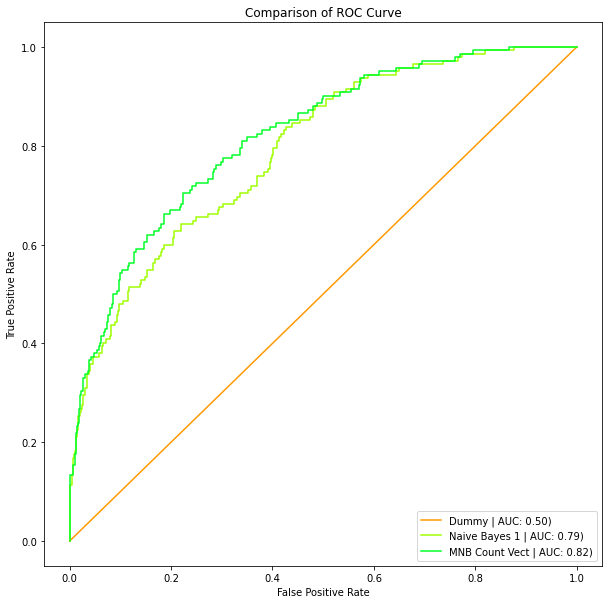

In [439]:
mnb1.compare_roc_curve()

# Further Model Iteration

# Reminder of Variables That Have Been Created:
- X_train_transformed, X_test_transformed - both TF-IDF vectorizations
- Xt_count, X_test_count - both Count Vectorizer transformations
- y_train/y_test still totally valid

At the end of one day of modeling, so far we have defined a class, defined several functions, and treated our data with the several preprocessing techniques. The features that we are analyzing so far are only the tokenized lemmatized tweets and whether or not that tweet pertained to a specific brand. Tomorrow, I will follow up on different types of models, and will likely move into muti-class classification.

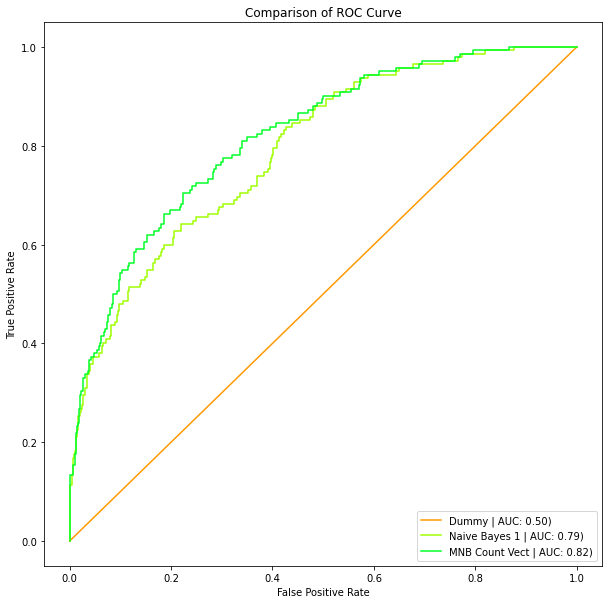

In [429]:
colors = sns.color_palette(palette='gist_rainbow')
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(Model.model_list)):
    # get the predict_proba values
    y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

    # Get the FPR and TPR data
    fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
    # Plot the actual graph
    ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')

ax.set_title(f"Comparison of ROC Curve")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right');